# **Text Summarisation from Scratch using Seq2Seq model:** <br>
### **What is Seq2Seq Model?**
 Sequence to Sequence (often abbreviated to seq2seq) models is a special class of Recurrent Neural Network architectures that we typically use (but not restricted) to solve complex Language problems like Machine Translation, Question Answering, creating Chatbots, Text Summarization, etc. It is composed of a encoder and decoder.
#### **Encoder :** <br>
Both encoder and the decoder are LSTM models (or sometimes GRU models)
Encoder reads the input sequence and summarizes the information in something called the internal state vectors or context vector (in case of LSTM these are called the hidden state and cell state vectors). We discard the outputs of the encoder and only preserve the internal states. This context vector aims to encapsulate the information for all input elements in order to help the decoder make accurate predictions.The LSTM reads the data, one sequence after the other. Thus if the input is a sequence of length ‘t’, we say that LSTM reads it in ‘t’ time steps.
<li>
1. Xi = Input sequence at time step i.
<li>
2. hi and ci = LSTM maintains two states (‘h’ for hidden state and ‘c’ for cell state) at each time step. Combined together these are internal state of the LSTM at time step i.
<li>
3. Yi = Output sequence at time step i. Yi is actually a probability distribution over the entire vocabulary which is generated by using a softmax activation. Thus each Yi is a vector of size “vocab_size” representing a probability distribution.

#### **Decoder :**

The decoder is an LSTM whose initial states are initialized to the final states of the Encoder LSTM, i.e. the context vector of the encoder’s final cell is input to the first cell of the decoder network. Using these initial states, the decoder starts generating the output sequence, and these outputs are also taken into consideration for future outputs.
A stack of several LSTM units where each predicts an output y_t at a time step t.
<li>
Each recurrent unit accepts a hidden state from the previous unit and produces and output as well as its own hidden state.We calculate the outputs using the hidden state at the current time step together with the respective weight W(S). Softmax is used to create a probability vector which will help us determine the final output (e.g. word in the question-answering problem).
The most important point is that the initial states (h0, c0) of the decoder are set to the final states of the encoder. This intuitively means that the decoder is trained to start generating the output sequence depending on the information encoded by the encoder.
<li>
Finally, the loss is calculated on the predicted outputs from each time step and the errors are backpropagated through time in order to update the parameters of the network. Training the network over a longer period with a sufficiently large amount of data results in pretty good predictions.
During inference, we generate one word at a time.
<li>
The initial states of the decoder are set to the final states of the encoder.
The initial input to the decoder is always the START token.
At each time step, we preserve the states of the decoder and set them as initial states for the next time step.
At each time step, the predicted output is fed as input in the next time step.
We break the loop when the decoder predicts the END token.
    



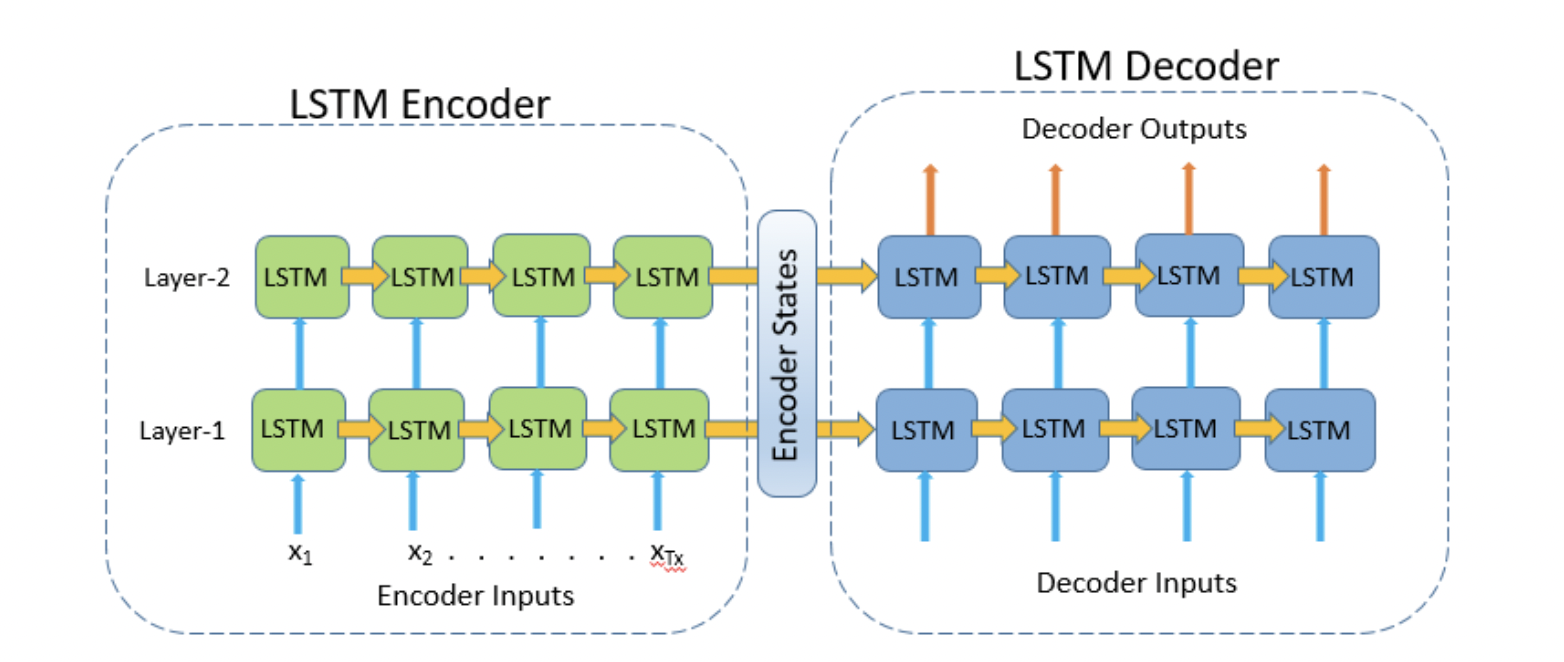

### Abstractive Summarisation:

Abstractive text summarization is a technique in which the summary is generated by generating novel sentences by either rephrasing or using the new words, instead of simply extracting the important sentences. For example, some questions in the reading comprehension might not be straightforward. In such cases we do rephrasing or use new words to answer such questions.

In [1]:
#using third party attention layer from https://github.com/thushv89/attention_keras as there is no attention mechanism in Keras implementation
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [2]:
import pandas as pd
import numpy as np
df=pd.read_csv("../input/wikihow-summarization/wikihowAll.csv")[:4001]
df.head()

,headline,title,text
0,"\nKeep related supplies in the same area.,\nMa...",How to Be an Organized Artist1,"If you're a photographer, keep all the necess..."
1,\nCreate a sketch in the NeoPopRealist manner ...,How to Create a Neopoprealist Art Work,See the image for how this drawing develops s...
2,"\nGet a bachelor’s degree.,\nEnroll in a studi...",How to Be a Visual Effects Artist1,It is possible to become a VFX artist without...
3,\nStart with some experience or interest in ar...,How to Become an Art Investor,The best art investors do their research on t...
4,"\nKeep your reference materials, sketches, art...",How to Be an Organized Artist2,"As you start planning for a project or work, ..."


In [3]:
df['text'][2].replace('\n',' ')

' It is possible to become a VFX artist without a college degree, but the path is often easier with one. VFX artists usually major in fine arts, computer graphics, or animation. Choose a college with a reputation for strength in these areas and a reputation for good job placement for graduates. The availability of internships is another factor to consider.Out of the jobs advertised for VFX artists, a majority at any given time specify a bachelor’s degree as a minimum requirement for applicants.; , Some studios offer short-term programs for people who want to learn more about VFX artistry without pursuing a college degree. Enrolling in these programs can be expensive as financial aid isn’t always offered, but they usually have the most cutting edge technology for you to learn from., Although you may create some hand sketches, the majority of your work will be completed on the computer using the most up-to-date programs. Stay informed about the newest software advances by following VFX b

In [4]:
unique_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [5]:
#clean data using helper code
import re
def transform(summary):
    # Lower case
    summary = summary.lower()
    summary=summary.replace('\n',' ')
    # Remove HTML
    summary = re.sub('<br /><br />', ' ', summary)
       
    # Replace all non-alphanumeric characters with spaces
    summary = re.sub(r'[^a-zA-Z0-9\s]', '', summary)
    # removing contractions
    summary=' '.join([unique_mapping[t] if t in unique_mapping else t for t in summary.split(" ")]) 
    
    return summary

In [6]:
df['headline']=df['headline'].apply(lambda x:transform(str(x)))
df['text']=df['text'].apply(lambda x:transform(str(x)))
df['title']=df['title'].apply(lambda x:transform(str(x)))

In [7]:
#checking out the cleaned data
df.head()

,headline,title,text
0,keep related supplies in the same area make a...,how to be an organized artist1,if youre a photographer keep all the necessar...
1,create a sketch in the neopoprealist manner o...,how to create a neopoprealist art work,see the image for how this drawing develops s...
2,get a bachelors degree enroll in a studiobase...,how to be a visual effects artist1,it is possible to become a vfx artist without...
3,start with some experience or interest in art...,how to become an art investor,the best art investors do their research on t...
4,keep your reference materials sketches articl...,how to be an organized artist2,as you start planning for a project or work y...


In [8]:
#we consider only the headline and text
df=df[['headline','text']]

##### Here we are going to use the text as the input and headline as our target, i.e abstractively summarised.

In [9]:
df['headline']=df['headline'].apply(lambda x: 'sostok '+str(x)+' eostok')

In [10]:
df['word_count_text']=df['text'].apply(lambda x:len(str(x).split()))
for i in range(0,100,10):
    var=df['word_count_text'].values
    var=np.sort(var,axis=None)
    print("{} percentile is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is",var[-1])
    

0 percentile is 0
10 percentile is 157
20 percentile is 224
30 percentile is 280
40 percentile is 335
50 percentile is 395
60 percentile is 475
70 percentile is 600
80 percentile is 818
90 percentile is 1218
100 percentile value is 4219


In [11]:
for i in range(60,70):
    var=df['word_count_text'].values
    var=np.sort(var,axis=None)
    print("{} percentile is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is",var[-1])

60 percentile is 475
61 percentile is 485
62 percentile is 496
63 percentile is 509
64 percentile is 520
65 percentile is 537
66 percentile is 549
67 percentile is 560
68 percentile is 572
69 percentile is 584
100 percentile value is 4219


In [12]:
#truncating to 63rd percentile
max_length=509
max_len_headlines=128

In [13]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(df['text'],df['headline'],test_size=0.2,random_state=1,shuffle=True)

### Pre-trained word embeddings: 

In [14]:
#tokenisation
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [15]:
#Find the percentage of occurrence of rare words in the text.
thresh = 5

count = 0
tot_count = 0
x_tokenizer=tf.keras.preprocessing.text.Tokenizer(
    num_words=tot_count,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=True,
)
x_tokenizer.fit_on_texts(list(x_tr))

for key, value in x_tokenizer.word_counts.items():
    tot_count = tot_count + 1
    if value < thresh:
        count = count + 1
    
print("% of rare words in vocabulary: ", (count / tot_count) * 100)

% of rare words in vocabulary:  71.34254961487318


In [16]:
tot_count

39857

In [17]:
# # Prepare a tokenizer
x_tokenizer=tf.keras.preprocessing.text.Tokenizer(
    num_words=tot_count,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=True,
)
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = tf.keras.preprocessing.sequence.pad_sequences(x_tr_seq,  maxlen=max_length, padding='post')
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val_seq, maxlen=max_length, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 39858


In [18]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

count = 0
tot_count = 0

for key, value in y_tokenizer.word_counts.items():
    tot_count = tot_count + 1
    if value < thresh:
        count = count + 1
    
print("% of rare words in vocabulary:",(count / tot_count) * 100)

# Prepare a tokenizer
y_tokenizer = Tokenizer(num_words=tot_count) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = tf.keras.preprocessing.sequence.pad_sequences(y_tr_seq, maxlen=max_len_headlines, padding='post')
y_val = tf.keras.preprocessing.sequence.pad_sequences(y_val_seq, maxlen=max_len_headlines, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 71.49321266968326
Size of vocabulary in Y = 10830


In [19]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []

for i in range(len(y_tr)):
    count = 0
    for j in y_tr[i]:
        if j != 0:
            count = count + 1
    if count == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [20]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    count = 0
    for j in y_val[i]:
        if j != 0:
            count = count + 1
    if count == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense,Concatenate, TimeDistributed,GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

##### In the model we use a timedistributed dense layer at the decoder end.This wrapper allows us to apply a layer to every temporal slice of an input.This does two important things:

##### <li> Allows the problem to be framed and learned as it was defined, that is one input to one output, keeping the internal process for each time step separate.</li>
##### <li> Simplifies the network by requiring far fewer weights such that only one time step is processed at a time.</li>



In [22]:
#latent_dim denotes the number of hidden units.
from keras import backend as K 
K.clear_session()

latent_dim = 200
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_length,))

#embedding layer
encoder_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Setting up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
decoder_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
decoder_emb = decoder_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(decoder_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concatenating attention 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


2022-07-28 11:56:04.878011: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 509)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 509, 100)     3985800     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 509, 200), ( 240800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [36]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [24]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=3,
    callbacks=[es],
    batch_size=16,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

2022-07-28 11:56:06.812191: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
200/200 [==============================] - 2530s 13s/step - loss: 2.8739 - val_loss: 2.3008
Epoch 2/3
200/200 [==============================] - 2504s 13s/step - loss: 2.4915 - val_loss: 2.2279
Epoch 3/3
200/200 [==============================] - 2480s 12s/step - loss: 2.3881 - val_loss: 2.1438


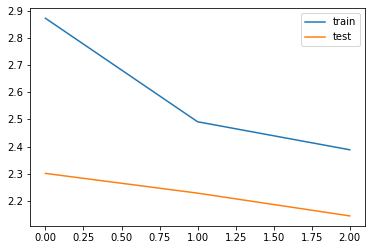

In [25]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [26]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index


In [27]:
# Inference Models for understanding our outputs where the prediction takes place using the context vector

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_length,latent_dim))

# Get the embeddings of the decoder sequence
decoder_emb2= decoder_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [28]:
def intepreting_sequence(input_seq):

    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_len_headlines-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [29]:
# To summarise
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# for sequences to texts
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [35]:
seqtxt=[]
seqsum=[]
predsum=[]
for i in range(0,3):
    print ('Review:', seq2text(x_tr[i]))
    seqtxt.append(seq2text(x_tr[i]).split(" "))
    print ('\n')
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('\n')
    seqsum.append(seq2summary(y_tr[i]).split(" "))
    predicted=intepreting_sequence(x_tr[i].reshape(1,max_length))
    print ('Predicted summary:',predicted)
    predsum.append(predicted)
    print ('\n')

Review: soporific means sleepinducing for example some foods are high in the sleepinducing amino acid tryptophan like cheese chicken soy products eggs tofu fish milk turkey nuts peanuts and peanut butter pumpkin seeds and sesame seeds choose foods that have these qualities especially for dinner to activate tryptophan more efficiently favor foods that are high in complex carbohydrates but medium to low in protein carbs make tryptophan more available in the brain whereas protein has the opposite effect plan meals for sleep that load up on complex carbs and tryptophan try pasta with parmesan cheese hummus with whole wheat pita bread peanut butter on toast sesame seeds sprinkled on salad with tuna chunks with whole wheat crackers on the side or a baked potato with cottage cheese limit the amount of food that you eat in the late afternoon and early evening as it can affect the quality of your sleep lighter meals are more likely to give you a restful night for example whereas highfat meals a

In [47]:
from nltk.translate.bleu_score import sentence_bleu
scores=0
for i in range(len(predsum)):
    reference = [predsum[i].split(" ")]
    candidate = seqsum[i]
    scores+= sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
print(scores/i)

0.05248061319474946


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [50]:
!pip install rouge-score
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

In [57]:
scores=[]
for i in range(len(predsum)):
    reference = predsum[i]
    candidate = ' '.join(seqsum[i])
    print(scorer.score(reference,candidate)['rouge1'])
    scores.append(scorer.score(reference,candidate)['rouge1'])
#print(scores/i)

Score(precision=0.08695652173913043, recall=0.015748031496062992, fmeasure=0.026666666666666665)
Score(precision=0.09448818897637795, recall=0.09448818897637795, fmeasure=0.09448818897637794)
Score(precision=0.038461538461538464, recall=0.007874015748031496, fmeasure=0.0130718954248366)


In [62]:
np.mean([i[2] for i in scores])

0.044742250355960404